# KerasCV로 시맨틱 세그멘테이션

**저자:** [Divyashree Sreepathihalli](https://github.com/divyashreepathihalli), [Ian Stenbit](https://github.com/ianstenbit)  
**생성일:** 2023/08/22  
**최종편집일:** 2023/08/24  
**설명:** KerasCV를 사용하여 DeepLabv3+ 세그멘테이션 모델을 트레이닝하고 사용합니다.

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_intermediate.png)

## 배경

시맨틱 세그멘테이션은 사람, 자전거 또는 배경과 같은 클래스 레이블을 이미지의 각 픽셀에 할당하여,
이미지를 서로 다른 객체 클래스나 범주에 해당하는 영역으로,
효과적으로 분할하는 일종의 컴퓨터 비전 작업입니다.

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*z6ch-2BliDGLIHpOPFY_Sw.png)

KerasCV는 시맨틱 세그멘테이션을 위해 Google에서 개발한 DeepLabv3+ 모델을 제공합니다.
이 가이드는 KerasCV를 사용하여 이미지 시맨틱 세그멘테이션을 위해,
DeepLabv3+ 모델을 미세 조정하고 사용하는 방법을 보여줍니다.
아트러스(atrous) 컨볼루션, 문맥 정보 집계(contextual information aggregation) 및
강력한 백본을 결합하여 정확하고 자세한 시맨틱 세그멘테이션을 달성하는 아키텍처입니다.
DeepLabv3+ 모델은 다양한 이미지 세그멘테이션 벤치마크에서 최첨단 결과를 달성하는 것으로 나타났습니다.


### 참조

- [시맨틱 이미지 세그멘테이션을 위한, Atrous Separable 컨볼루션을 갖춘 인코더-디코더](https://arxiv.org/abs/1802.02611)  
- [시맨틱 이미지 세그멘테이션을 위한, Atrous 컨볼루션 재고](https://arxiv.org/abs/1706.05587)

## 셋업 및 import

종속성을 설치하고 필요한 모듈을 import 해 보겠습니다.

이 튜토리얼을 실행하려면, 다음 패키지를 설치해야 합니다.

*   `keras-cv`
*   `keras-core`

## Setup and Imports

Let's install the dependencies and import the necessary modules.

To run this tutorial, you will need to install the following packages:

* `keras-cv`
* `keras-core`

In [1]:
# 이 노트북은 Keras cv가 설치되어 있다는 가정 하에 진행됩니다.
# 이 노트북은 Keras 3이 설치되어 있다는 가정 하에 진행됩니다.
#
# !pip install -q --upgrade keras-cv
# !pip install -q --upgrade keras  # Upgrade to Keras 3.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"

In [3]:
from keras import backend

print(backend.backend())

tensorflow


In [4]:
import keras

print(keras.__version__)

3.4.1


`keras-core`와 `keras-cv`를 설치한 후,
`keras-core`에 대한 백엔드를 설정합니다.
이 가이드는 모든 백엔드(Tensorflow, JAX, PyTorch)에서 실행할 수 있습니다.

```python
import os

os.environ["KERAS_BACKEND"] = "jax"
```

In [5]:
import keras
from keras import ops

import keras_cv
import numpy as np

from keras_cv.datasets.pascal_voc.segmentation import load as load_voc

## 사전 트레이닝된 DeepLabv3+ 모델을 사용하여 시맨틱 세그멘테이션 수행

KerasCV 시맨틱 세그멘테이션 API에서 가장 높은 레벨의 API는 `keras_cv.models` API입니다.
이 API에는,
[`keras_cv.models.DeepLabV3Plus`](https://codecompose7.github.io/keras-doc-kr.github.io/api/keras_cv/models/tasks/deeplab_v3_segmentation#deeplabv3plus-class)와 같은,
완전히 사전 트레이닝된된 시맨틱 세그멘테이션 모델이 포함됩니다.

pascalvoc 데이터 세트에 대해 사전 트레이닝된 DeepLabv3+를 구성하여 시작해 보겠습니다.

In [6]:
model = keras_cv.models.DeepLabV3Plus.from_preset(
    "deeplab_v3_plus_resnet50_pascalvoc",
    num_classes=21,
    input_shape=[512, 512, 3],
)

100%|██████████| 10.5k/10.5k [00:00<00:00, 3.58MB/s]
100%|██████████| 150M/150M [00:09<00:00, 16.1MB/s]


이 사전 트레이닝된 모델의 결과를 시각화해 보겠습니다.

1215963/1215963 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


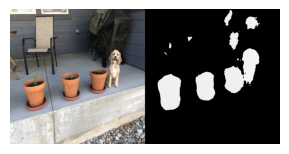

In [7]:
# filepath = keras.utils.get_file(origin="https://i.imgur.com/gCNcJJI.jpg")
filepath = keras.utils.get_file(origin="https://github.com/tenkeyless/keras-io_test/blob/main/assets/gCNcJJI.jpeg?raw=true")
image = keras.utils.load_img(filepath)

resize = keras_cv.layers.Resizing(height=512, width=512)
image = resize(image)
image = keras.ops.expand_dims(np.array(image), axis=0)
preds = ops.expand_dims(ops.argmax(model(image), axis=-1), axis=-1)
keras_cv.visualization.plot_segmentation_mask_gallery(
    image,
    value_range=(0, 255),
    num_classes=1,
    y_true=None,
    y_pred=preds,
    scale=3,
    rows=1,
    cols=1,
)

## 커스텀 시맨틱 세그멘테이션 모델 트레이닝

이 가이드에서는, KerasCV DeepLabV3 시맨틱 세그멘테이션 모델을 위한,
전체 트레이닝 파이프라인을 조립합니다.
여기에는 데이터 로딩, 보강, 트레이닝, 메트릭 평가 및 추론이 포함됩니다!

## 데이터 다운로드

KerasCV 데이터세트와 함께 [Pascal VOC 데이터세트](https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz)를 다운로드하고,
이를 트레이닝 데이터세트 `train_ds`와 `eval_ds`로 분할합니다.

In [8]:
train_ds = load_voc(split="sbd_train")
eval_ds = load_voc(split="sbd_eval")

1419539633/1419539633 ━━━━━━━━━━━━━━━━━━━━ 1741s 1us/step


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


## 데이터 전처리

`preprocess_tfds_inputs` 유틸리티 함수는,
`images`와 `segmentation_masks` 딕셔너리에 대한 입력을 전처리합니다.
이미지와 세그먼테이션 마스크는 512x512로 크기가 조정됩니다.
그런 다음, 결과 데이터 세트는 4개의 이미지와 세그먼테이션 마스크 쌍으로 구성된 그룹으로 배치됩니다.

이 전처리된 입력 트레이닝 데이터의 배치는 `keras_cv.visualization.plot_segmentation_mask_gallery` 함수를 사용하여 시각화할 수 있습니다.
이 함수는 이미지와 세그먼테이션 마스크의 배치를 입력으로 사용하여 그리드에 표시합니다.

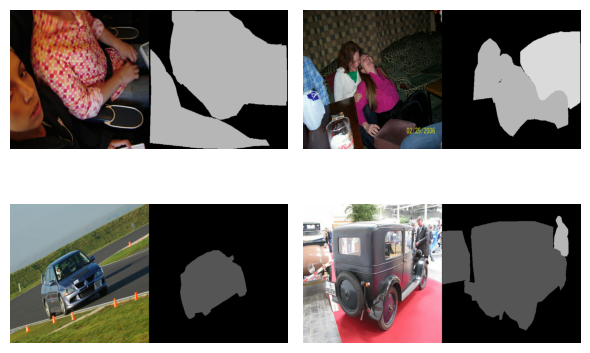

In [9]:
def preprocess_tfds_inputs(inputs):
    def unpackage_tfds_inputs(tfds_inputs):
        return {
            "images": tfds_inputs["image"],
            "segmentation_masks": tfds_inputs["class_segmentation"],
        }

    outputs = inputs.map(unpackage_tfds_inputs)
    outputs = outputs.map(keras_cv.layers.Resizing(height=512, width=512))
    outputs = outputs.batch(4, drop_remainder=True)
    return outputs


train_ds = preprocess_tfds_inputs(train_ds)
batch = train_ds.take(1).get_single_element()
keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,  # Oxford iiit pet 데이터세트의 클래스 수. VOC 데이터세트에는 배경에 대한 클래스 1개도 포함됩니다.
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

전처리는 평가 데이터 세트 `eval_ds`에 적용됩니다.

In [10]:
eval_ds = preprocess_tfds_inputs(eval_ds)

## 데이터 보강

KerasCV는 다양한 이미지 보강 옵션을 제공합니다.
이 예에서는 `RandomFlip` 보강을 사용하여, 트레이닝 데이터 세트를 보강합니다.
`RandomFlip` 보강은 트레이닝 데이터 세트의 이미지를 수평 또는 수직으로 랜덤으로 뒤집습니다.
이는 이미지의 객체 방향 변화에 대한 모델의 견고성을 개선하는 데 도움이 될 수 있습니다.

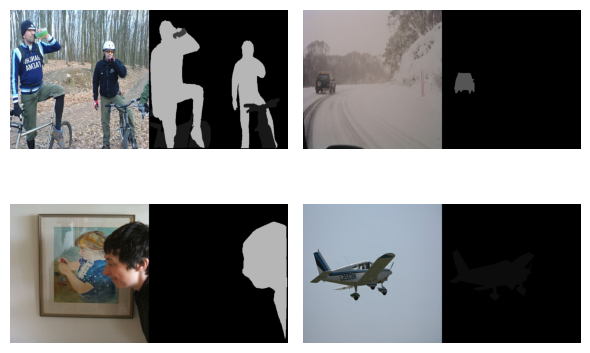

In [11]:
train_ds = train_ds.map(keras_cv.layers.RandomFlip())
batch = train_ds.take(1).get_single_element()

keras_cv.visualization.plot_segmentation_mask_gallery(
    batch["images"],
    value_range=(0, 255),
    num_classes=21,
    y_true=batch["segmentation_masks"],
    scale=3,
    rows=2,
    cols=2,
)

## 모델 구성

모델 트레이닝을 위한 구성을 자유롭게 수정하고, 트레이닝 결과가 어떻게 변경되는지 확인하세요.
이것은 트레이닝 파이프라인을 더 잘 이해하는 데 좋은 연습입니다.

학습률 스케쥴은 옵티마이저에서 각 에포크에 대한 학습률을 계산하는 데 사용됩니다.
그런 다음, 옵티마이저에서 학습률을 사용하여 모델의 가중치를 업데이트합니다.
이 경우, 학습률 스케쥴은 코사인 감쇠(cosine decay) 함수를 사용합니다.
코사인 감쇠 함수는 높은 곳에서 시작한 다음, 시간이 지남에 따라 감소하여 결국 0에 도달합니다.
VOC 데이터 세트의 cardinality는 2124이고 배치 크기는 4입니다.
데이터 세트 cardinality는 모델이 학습할 단계 수를 결정하기 때문에, 학습률 감쇠(learning rate decay)에 중요합니다.
초기 학습률은 0.007에 비례하고, 감소 단계는 2124입니다.
즉, 학습률은 `INITIAL_LR`에서 시작한 다음, 2124단계에 걸쳐 0으로 감소합니다.

In [12]:
BATCH_SIZE = 4
INITIAL_LR = 0.007 * BATCH_SIZE / 16
EPOCHS = 1
NUM_CLASSES = 21
learning_rate = keras.optimizers.schedules.CosineDecay(
    INITIAL_LR,
    decay_steps=EPOCHS * 2124,
)

ImageNet 분류에 대해 사전 트레이닝된 ResNet50 백본을 사용하여,
DeepLabV3+ 모델을 인스턴스화합니다.
사전 트레이닝된 가중치 `resnet50_v2_imagenet`은
DeepLabV3Plus 모델의 백본 특성 추출기로 사용됩니다.
`num_classes` 매개변수는 모델이 세그멘테이션하도록 트레이닝될 클래스 수를 지정합니다.

In [13]:
model = keras_cv.models.DeepLabV3Plus.from_preset(
    "resnet50_v2_imagenet", num_classes=NUM_CLASSES
)


100%|██████████| 886/886 [00:00<00:00, 370kB/s]
100%|██████████| 90.3M/90.3M [00:07<00:00, 12.9MB/s]


## 모델 컴파일

`model.compile()` 함수는 모델의 트레이닝 프로세스를 설정합니다.

이는 다음을 정의합니다.

- 옵티마이저 알고리즘
- 확률적 경사 하강법(SGD)
- 손실 함수
- 카테고리 교차 엔트로피
- 평가 지표
- 평균 IoU 및 카테고리 정확도

시맨틱 세그멘테이션 평가 지표:

- 평균 교집합(MeanIoU, Mean Intersection over Union):
  MeanIoU는 시맨틱 세그멘테이션 모델이 이미지에서,
  다른 객체나 영역을 얼마나 정확하게 식별하고 구분하는지 측정합니다.
  예측된 객체 경계와 실제 객체 경계 사이의 중첩을 계산하여,
  0~1 사이의 점수를 제공하며, 1은 완벽한 일치를 나타냅니다.
- 카테고리 정확도: 카테고리 정확도는 이미지에서 올바르게 분류된 픽셀의 비율을 측정합니다.
  모델이 전체 이미지에서 픽셀 카테고리를 얼마나 정확하게 예측하는지를 나타내는 간단한 백분율을 제공합니다.

본질적으로 MeanIoU는 특정 객체 경계를 식별하는 정확도를 강조하는 반면,
카테고리 정확도는 전반적인 픽셀 레벨의 정확성에 대한 광범위한 개요를 제공합니다.

In [14]:
model.compile(
    optimizer=keras.optimizers.SGD(
        learning_rate=learning_rate, weight_decay=0.0001, momentum=0.9, clipnorm=10.0
    ),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.MeanIoU(
            num_classes=NUM_CLASSES, sparse_y_true=False, sparse_y_pred=False
        ),
        keras.metrics.CategoricalAccuracy(),
    ],
)

model.summary()

Model: "deep_lab_v3_plus_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_13             │ [(None, None, None,    │     23,556,608 │ input_layer_8[0][0]    │
│ (Functional)              │ 256), (None, None,     │                │                        │
│                           │ None, 2048)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_pyramid_pooling   │ (None, None, None,     │     15,538,176 │ functional_13[0][1]    │
│ (SpatialPyramidPooling)   │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_output_upsampling │ (None, None, None,     │              0 │ spatial_pyramid_pooli… │
│ (UpSampling2D)            │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_13             │ (None, None, None, 48) │         12,480 │ functional_13[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, None, None,     │              0 │ encoder_output_upsamp… │
│ (Concatenate)             │ 304)                   │                │ sequential_13[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_14             │ (None, None, None, 21) │         84,224 │ concatenate_1[0][0]    │
│ (Sequential)              │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 39,191,488 (149.50 MB)

 Trainable params: 39,146,464 (149.33 MB)

 Non-trainable params: 45,024 (175.88 KB)

유틸리티 함수 `dict_to_tuple`은 트레이닝 및 검증 데이터 세트의 딕셔너리를,
이미지와 원핫 인코딩된 세그멘테이션 마스크의 튜플로 효과적으로 변환합니다.
이 변환은 DeepLabv3+ 모델의 트레이닝 및 평가 중에 사용됩니다.

In [15]:
def dict_to_tuple(x):
    import tensorflow as tf

    return x["images"], tf.one_hot(
        tf.cast(tf.squeeze(x["segmentation_masks"], axis=-1), "int32"), 21
    )


train_ds = train_ds.map(dict_to_tuple)
eval_ds = eval_ds.map(dict_to_tuple)

model.fit(train_ds, validation_data=eval_ds, epochs=EPOCHS)

   2124/Unknown 571s 257ms/step - categorical_accuracy: 0.7413 - loss: 0.9815 - mean_io_u: 0.1691

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 627s 284ms/step - categorical_accuracy: 0.7413 - loss: 0.9814 - mean_io_u: 0.1692 - val_categorical_accuracy: 0.8324 - val_loss: 0.5209 - val_mean_io_u: 0.4077


## 트레이닝된 모델을 사용한 예측

이제 DeepLabv3+의 모델 트레이닝이 완료되었으므로,
몇 개의 샘플 이미지에 대한 예측을 통해 테스트해 보겠습니다.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


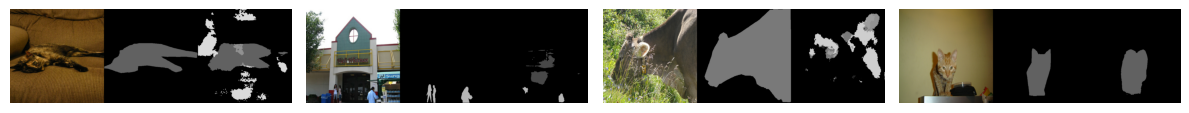

In [16]:
test_ds = load_voc(split="sbd_eval")
test_ds = preprocess_tfds_inputs(test_ds)

images, masks = next(iter(train_ds.take(1)))
images = ops.convert_to_tensor(images)
masks = ops.convert_to_tensor(masks)
preds = ops.expand_dims(ops.argmax(model(images), axis=-1), axis=-1)
masks = ops.expand_dims(ops.argmax(masks, axis=-1), axis=-1)

keras_cv.visualization.plot_segmentation_mask_gallery(
    images,
    value_range=(0, 255),
    num_classes=21,
    y_true=masks,
    y_pred=preds,
    scale=3,
    rows=1,
    cols=4,
)


KerasCV DeepLabv3+ 모델을 사용하기 위한 몇 가지 추가 팁은 다음과 같습니다.

* 모델은 COCO 데이터 세트, PASCAL VOC 데이터 세트, Cityscapes 데이터 세트를 포함한,
  다양한 데이터 세트에 대해 트레이닝될 수 있습니다.
* 모델은 커스텀 데이터 세트에 대해 미세 조정하여, 특정 작업에서 성능을 개선할 수 있습니다.
* 모델은 이미지에 대해 실시간 추론을 수행하는 데 사용할 수 있습니다.
* 또한 KerasCV의 SegFormer 모델 `keras_cv.models.segmentation.SegFormer`를 사용해 보세요.
  SegFormer 모델은 다양한 이미지 세그멘테이션 벤치마크에서,
  최첨단 결과를 달성하는 것으로 나타난 새로운 모델입니다.
  Swin Transformer 아키텍처를 기반으로 하며,
  이전 이미지 세그멘테이션 모델보다 효율적이고 정확합니다.
